<a href="https://colab.research.google.com/github/mkbahk/QuantumComputing/blob/main/QuantumSubroutineAlgorithms_QAA_GoogleAIStudio_mkbahk_20250407.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install qiskit[visualization]==1.2.4
%pip install qiskit-aer==0.15.1
%pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 5.7 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=7741739c62fcedd1ac07524b4391e35a9d1ef5b2e4fa457d4807cbdea1537d1e
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 53.6 MB/s eta 0:00:00
  Cloning https://github.com/qiskit-community/qiskit-textbook.git to /tmp/pip-req-build-s4pezpij
  Running comman

In [3]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, assemble
from qiskit.quantum_info import Statevector, Operator
from qiskit.visualization import plot_histogram, plot_state_city, plot_bloch_multivector
from qiskit_textbook.tools import array_to_latex
from qiskit_aer import Aer, AerSimulator
from IPython.display import display, Math
import numpy as np

from qiskit.primitives import Sampler
from qiskit.circuit.library import ZGate


#결과가 않나옴

In [29]:
# --- 1. 문제 정의 및 초기 설정 ---

# 사용할 큐비트 수
n_qubits = 3

# 찾고자 하는 "표시된" 상태 (이진 문자열 형태)
# 예: 3큐비트에서 |101> 상태를 찾고자 함. Qiskit은 오른쪽에서 왼쪽으로 큐비트 인덱싱 (q2 q1 q0)
# 따라서 '101'은 q2=1, q1=0, q0=1을 의미합니다.
marked_state_str = '101' # 이 값을 변경하여 다른 상태를 검색할 수 있습니다.

# 표시된 상태 문자열을 정수 리스트로 변환 (오라클 구성에 사용)
# '101' -> [1, 0, 1] (q0=1, q1=0, q2=1) - Qiskit은 q0이 가장 오른쪽
marked_state_list = [int(bit) for bit in marked_state_str[::-1]] # 문자열을 뒤집어서 Qiskit 순서에 맞춤

# --- 2. 오라클(Oracle) 함수 정의 ---
# 오라클은 "표시된" 상태의 위상만 -1로 바꿉니다. (U_f |x> = (-1)^f(x) |x>)
# 여기서 f(x) = 1 이면 x가 표시된 상태이고, f(x) = 0 이면 그렇지 않습니다.
def oracle(qc, marked_state_list_for_oracle):
    """
    표시된 상태의 위상을 뒤집는 오라클을 회로에 추가합니다.
    qc: QuantumCircuit 객체
    marked_state_list_for_oracle: 표시된 상태 (예: [1, 0, 1]은 |101>을 의미)
    """
    # 표시된 상태의 '0'인 비트에 해당하는 큐비트에 X 게이트를 적용하여 일시적으로 '1'로 만듭니다.
    # 이렇게 하면 모든 큐비트가 '1'일 때만 특정 연산이 적용되도록 할 수 있습니다.
    for qubit_index, bit_value in enumerate(marked_state_list_for_oracle):
        if bit_value == 0:
            qc.x(qubit_index) # 큐비트 qubit_index에 X 게이트 적용
        ###if
    ###for

    # 다중 제어 Z 게이트 (Multi-Controlled Z gate, MCZ)
    # 모든 제어 큐비트가 |1> 상태일 때 대상 큐비트의 위상을 뒤집습니다.
    # 여기서는 n_qubits-1개의 제어 큐비트와 1개의 대상 큐비트를 사용합니다.
    # 대상 큐비트는 마지막 큐비트(n_qubits-1)로 하고, 나머지 큐비트들을 제어 큐비트로 사용합니다.
    if n_qubits > 1:
        qc.mcx(list(range(n_qubits - 1)), n_qubits - 1) # Multi-Controlled Toffoli. MCZ는 H-MCX-H로 구성 가능
                                                     # 또는, qc.h(n_qubits-1)
                                                     # qc.mct(list(range(n_qubits-1)), n_qubits-1)
                                                     # qc.h(n_qubits-1)
                                                     # 더 간단하게는 CZ 또는 CCZ 등을 사용할 수 있지만,
                                                     # 여기서는 일반적인 MCZ를 위해 mct (multi-controlled Toffoli) 후 H로 Z로 변환하는 방식.
                                                     # Qiskit에는 직접적인 mcz가 없으므로, mcp(phase, controls, target) 사용 가능.
                                                     # Z = diag(1, -1) 이므로 phase = pi
        # 더 간단한 방법: 표시된 상태에만 Z를 적용하는 controlled_Z
        # qc.h(n_qubits -1)
        # qc.mct(list(range(n_qubits-1)), n_qubits-1) # target qubit의 상태를 뒤집음 (X)
        # qc.h(n_qubits -1)
        # 위 방식은 Toffoli(X) 이므로, Z로 바꾸려면 타겟에 H를 앞뒤로 적용
        # 또는, 위상을 바꾸는 mcp(multi-controlled phase) 사용
        # qc.mcp(np.pi, list(range(n_qubits-1)), n_qubits-1) # 이 방법이 더 정확함.

        # 가장 간단한 오라클 구현 (Qiskit의 control 메서드 활용):
        # 특정 상태(marked_state_str)일 때만 Z 게이트를 적용하는 것과 동일
        # 아래는 이 방식 대신 수동으로 구성한 예시입니다.
        # from qiskit.circuit.library import ZGate
        # controlled_z_gate = ZGate().control(num_ctrl_qubits=n_qubits-1, ctrl_state=marked_state_str[:-1]) # 마지막 큐비트를 타겟으로
        # qc.append(controlled_z_gate, list(range(n_qubits-1)) + [n_qubits-1])
        # 이 방법은 ctrl_state를 설정해야 해서 조금 복잡해짐.

        # 간단화: 타겟 큐비트에 H 적용, MCX, 타겟 큐비트에 H 적용
        qc.h(n_qubits - 1) # 마지막 큐비트에 H 게이트 적용
        qc.mcx(list(range(n_qubits - 1)), n_qubits - 1) # 제어 큐비트들이 모두 1일 때 마지막 큐비트에 X 게이트 적용
        qc.h(n_qubits - 1) # 마지막 큐비트에 H 게이트 다시 적용 (H-X-H = Z)
    elif n_qubits == 1: # 큐비트가 하나일 경우 Z 게이트만 적용
        qc.z(0)
    ###if

    # X 게이트를 다시 적용하여 큐비트 상태를 원래대로 복원합니다.
    for qubit_index, bit_value in enumerate(marked_state_list_for_oracle):
        if bit_value == 0:
            qc.x(qubit_index) # 큐비트 qubit_index에 X 게이트 적용
        ###if
    ###for

    qc.barrier() # 회로의 가독성을 위해 배리어 추가
###def

# --- 3. 확산 연산자(Diffusion Operator) 또는 진폭 증폭 연산자(Amplitude Amplification Operator) 정의 ---
# 확산 연산자는 모든 상태의 진폭을 평균 진폭에 대해 반전시킵니다. (U_s = 2|s><s| - I)
# 여기서 |s>는 모든 가능한 상태의 균등 중첩 상태입니다.
# U_s는 H^⊗n U_0 H^⊗n 로 구현됩니다. U_0는 |0...0> 상태의 위상만 뒤집는 연산자입니다.
def diffuser(qc, n_qubits_in_diffuser):
    """
    평균에 대한 반전을 수행하는 확산 연산자를 회로에 추가합니다.
    qc: QuantumCircuit 객체
    n_qubits_in_diffuser: 확산 연산자를 적용할 큐비트 수
    """
    # 1. 모든 큐비트에 H 게이트 적용
    qc.h(range(n_qubits_in_diffuser))

    # 2. |0...0> 상태를 제외한 모든 상태의 위상을 뒤집는 연산자 (U_0의 변형)
    #    - 모든 큐비트에 X 게이트 적용 (|0...0> -> |1...1>)
    qc.x(range(n_qubits_in_diffuser))

    #    - 다중 제어 Z 게이트 (모든 큐비트가 |1>일 때 위상 반전)
    #      H-MCX-H 트릭을 사용하여 MCZ 구현
    if n_qubits_in_diffuser > 1:
        qc.h(n_qubits_in_diffuser - 1) # 마지막 큐비트에 H
        qc.mcx(list(range(n_qubits_in_diffuser - 1)), n_qubits_in_diffuser - 1) # (n-1)개 제어, 1개 타겟 MCX
        qc.h(n_qubits_in_diffuser - 1) # 마지막 큐비트에 H
    elif n_qubits_in_diffuser == 1: # 큐비트가 하나일 경우 Z 게이트
        qc.z(0)
    ###if

    #    - 모든 큐비트에 X 게이트 다시 적용 (상태 복원)
    qc.x(range(n_qubits_in_diffuser))

    # 3. 모든 큐비트에 H 게이트 다시 적용
    qc.h(range(n_qubits_in_diffuser))

    qc.barrier() # 회로의 가독성을 위해 배리어 추가

# --- 4. 양자 회로 생성 ---
# n_qubits 개의 양자 비트와 n_qubits 개의 고전 비트(측정 결과 저장용)로 회로 생성
qc = QuantumCircuit(n_qubits, n_qubits)

# 1. 초기화: 모든 큐비트를 균등 중첩 상태로 만듭니다. (하다마드 게이트 적용)
qc.h(range(n_qubits)) # 각 큐비트에 H 게이트 적용
qc.barrier() # 배리어 추가

# --- 5. 그로버 반복 (오라클과 확산 연산자 적용) ---
# 최적 반복 횟수: 약 (π/4) * sqrt(N/M)
# N = 2^n_qubits (총 상태 수), M = 1 (표시된 상태 수)
num_iterations = int(np.round((np.pi / 4) * np.sqrt(2**n_qubits / 1)))
if num_iterations == 0: # 최소 1번은 반복
    num_iterations = 1
###if

print(f"{n_qubits}개의 큐비트, 표시된 상태 '{marked_state_str}'")
print(f"그로버 반복 횟수: {num_iterations}")

# 그로버 연산 반복
for iteration in range(num_iterations):
    print(f"  반복 {iteration + 1}:")
    # 2. 오라클 적용: 표시된 상태의 위상을 뒤집습니다.
    print(f"    - 오라클 적용 (상태: {marked_state_list})")
    oracle(qc, marked_state_list)

    # 3. 확산 연산자 적용: 평균에 대해 진폭을 반전시켜 표시된 상태의 진폭을 증폭합니다.
    print(f"    - 확산 연산자 적용")
    diffuser(qc, n_qubits)
###for

# --- 6. 측정 ---
# 모든 양자 비트를 해당하는 고전 비트에 측정합니다.
qc.measure(range(n_qubits), range(n_qubits)) # 큐비트 0..n-1을 클래시컬 비트 0..n-1에 측정

3개의 큐비트, 표시된 상태 '101'
그로버 반복 횟수: 2
  반복 1:
    - 오라클 적용 (상태: [1, 0, 1])
    - 확산 연산자 적용
  반복 2:
    - 오라클 적용 (상태: [1, 0, 1])
    - 확산 연산자 적용


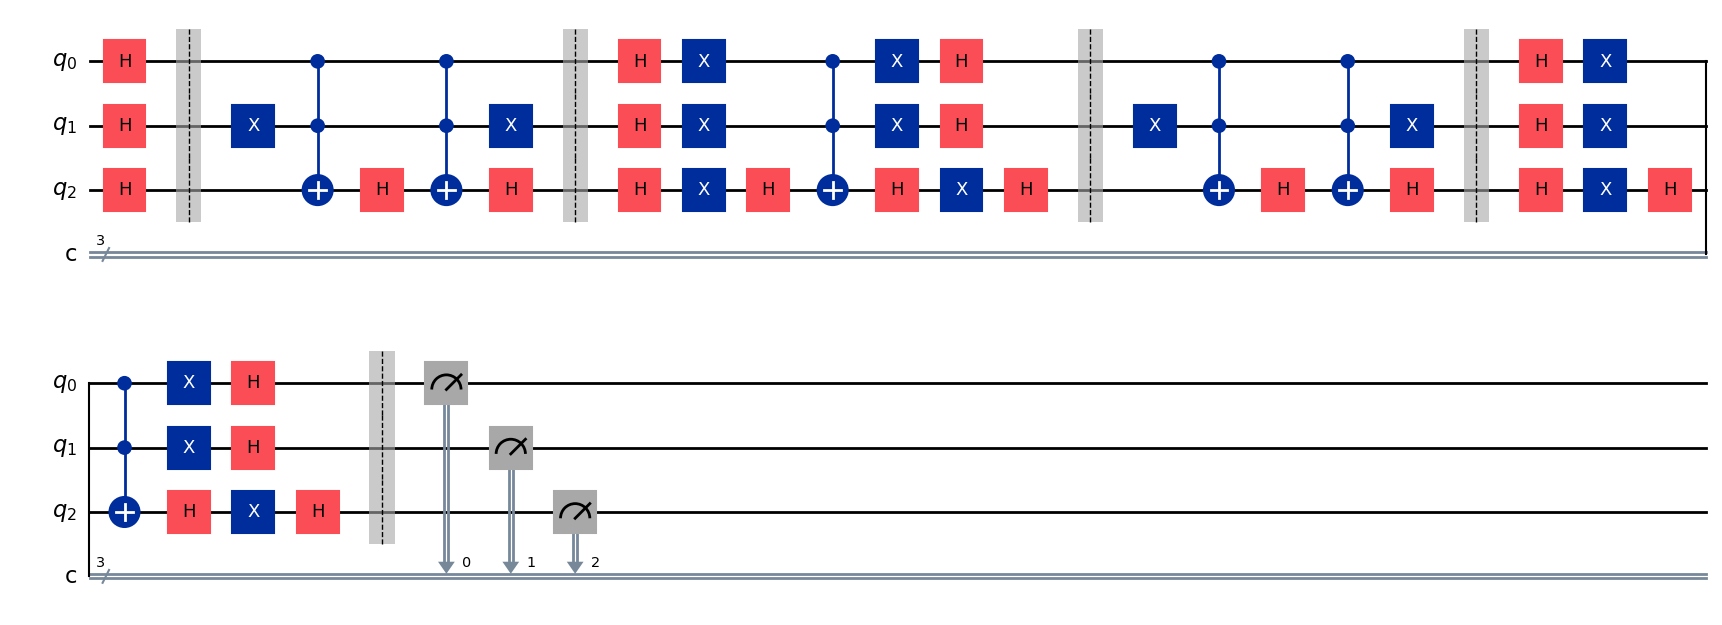

In [30]:
qc.draw(output='mpl') # 텍스트 기반 회로도 출력

In [31]:
# --- 7. 시뮬레이션 및 결과 확인 ---
# Aer 시뮬레이터 백엔드 사용
simulator = AerSimulator()

# 회로를 시뮬레이터에 맞게 트랜스파일
compiled_circuit = transpile(qc, simulator)

# 시뮬레이션 실행 (샷 수: 실험 반복 횟수)
job = simulator.run(compiled_circuit, shots=1024) # 1024번 실험 실행

# 결과 가져오기
result = job.result()

# 결과에서 측정된 횟수(counts) 가져오기
counts = result.get_counts(qc)

# 결과 출력
print("\n측정 결과:")
print(counts)


측정 결과:
{'101': 386, '010': 75, '000': 68, '110': 65, '001': 191, '011': 97, '111': 84, '100': 58}


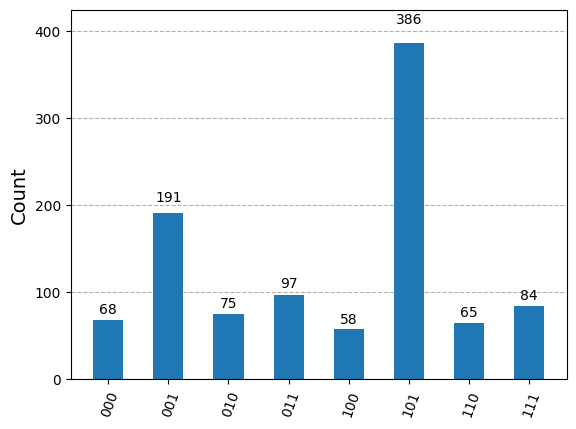

In [32]:
# 히스토그램으로 결과 시각화
plot_histogram(counts)